In [2]:
import numpy as np
from sklearn.base import clone
import random 
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from sklearn.ensemble import BaggingRegressor
from sklearn import decomposition
import math
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
# import dataframe_image as dfi

In [5]:
tur = pd.read_csv("F:\\Tara_Fall_2019\\Kenya_Drought\\Kenya_NDVI_analysis\\TURKANA_ANOMALIES.csv").set_index(["Unnamed: 0.1"])
nar = pd.read_csv("F:\\Tara_Fall_2019\\Kenya_Drought\\Kenya_NDVI_analysis\\NAROK_ANOMALIES.csv").set_index(["Unnamed: 0.1"])
tur = tur.rename(columns={'NDVI_anomaly': 'NDVI_z_score'})
nar = nar.rename(columns={'NDVI_anomaly': 'NDVI_z_score'})
tur.name = 'tur'
nar.name = "nar"

In [7]:
tur.index.unique()

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            65713, 65714, 65715, 65716, 65717, 65718, 65719, 65720, 65721,
            65722],
           dtype='int64', name='Unnamed: 0.1', length=65723)

In [3]:
tur["NDVI_dist"] = tur["NDVI_value"] - tur["mean_NDVI"]
nar["NDVI_dist"] = nar["NDVI_value"] - nar["mean_NDVI"]

In [4]:
# pull out negative and positive deviations from mean
tur_neg = tur[tur["NDVI_z_score"] > 0]
nar_neg = nar[nar["NDVI_z_score"] > 0]
tur_pos = tur[tur["NDVI_z_score"] < 0]
nar_pos = nar[nar["NDVI_z_score"] < 0]

tur_neg.name = "tur_neg"
nar_neg.name = "nar_neg"
tur_pos.name = "tur_pos"
nar_pos.name = "nar_pos"

In [330]:
low_ppt = tur[tur.sum_ppt < tur.sum_ppt.mean()*.50]

In [5]:
# pull out large negative and positive deviations from mean (deviations bigger than one standard deviation)
tur_big_pos = tur[tur["NDVI_z_score"] > 1]
nar_big_pos = nar[nar["NDVI_z_score"] > 1]
tur_big_neg = tur[tur["NDVI_z_score"] < -1]
nar_big_neg = nar[nar["NDVI_z_score"] < -1]

tur_big_pos.name = "tur_big_pos"
tur_big_neg.name = "tur_big_neg"
nar_big_pos.name = "nar_big_pos"
nar_big_neg.name = "nar_big_neg"

In [6]:
all_df = [tur, nar, tur_neg, tur_pos, nar_neg, nar_pos, tur_big_neg, tur_big_pos, nar_big_neg, nar_big_pos]

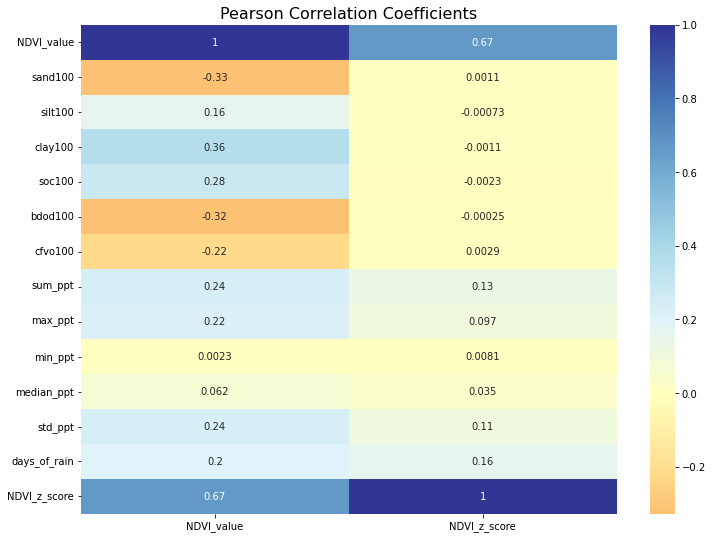

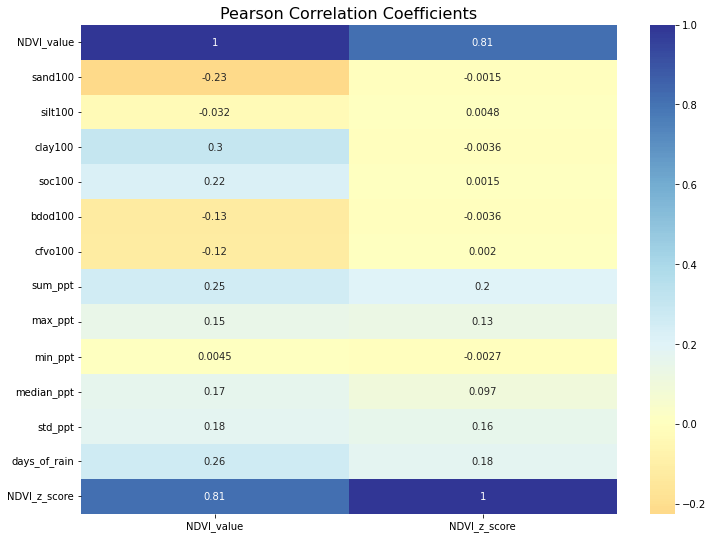

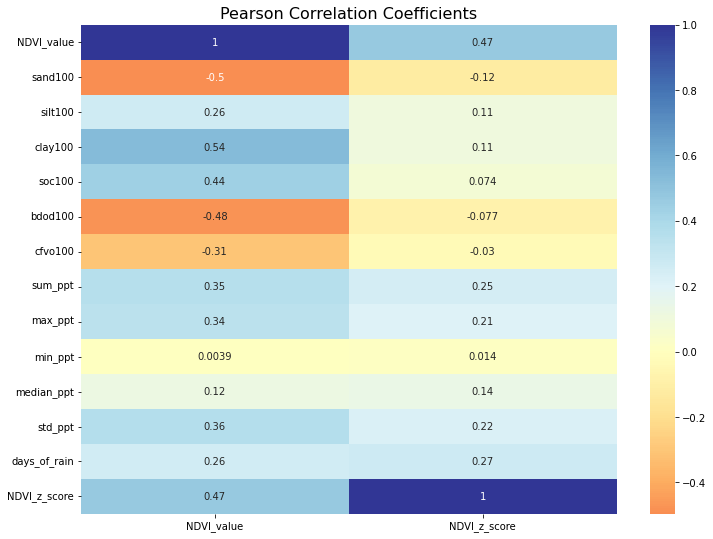

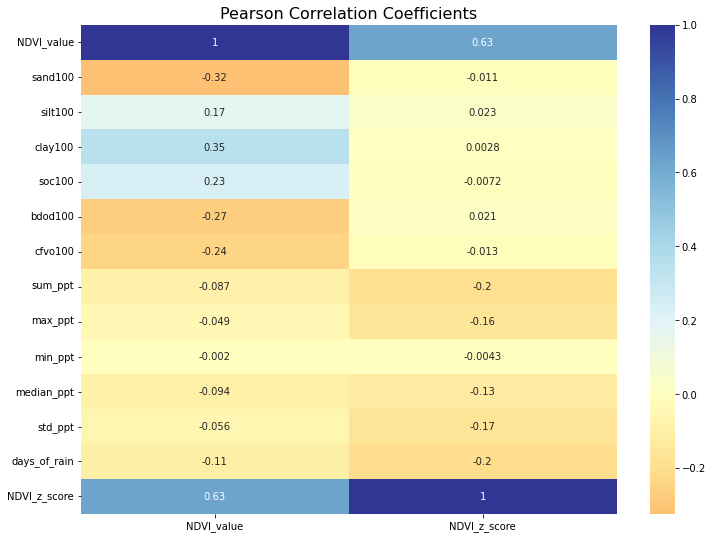

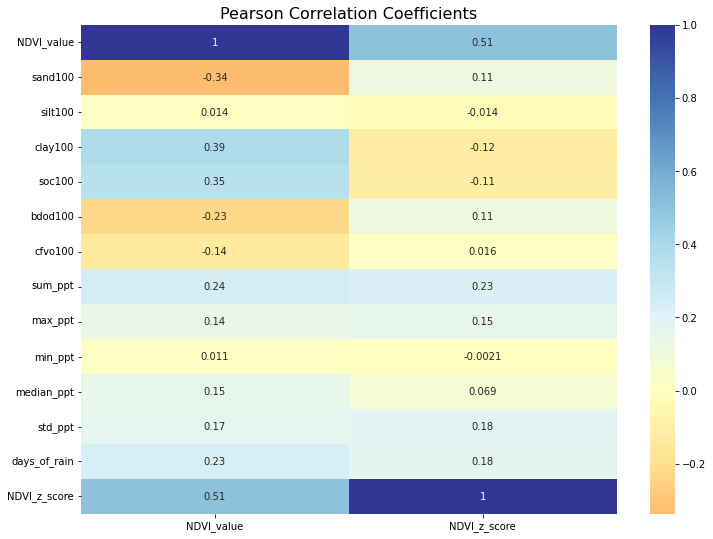

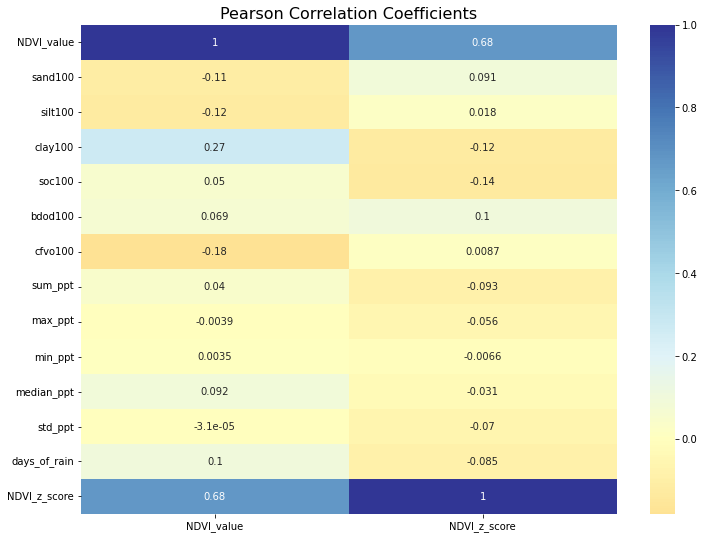

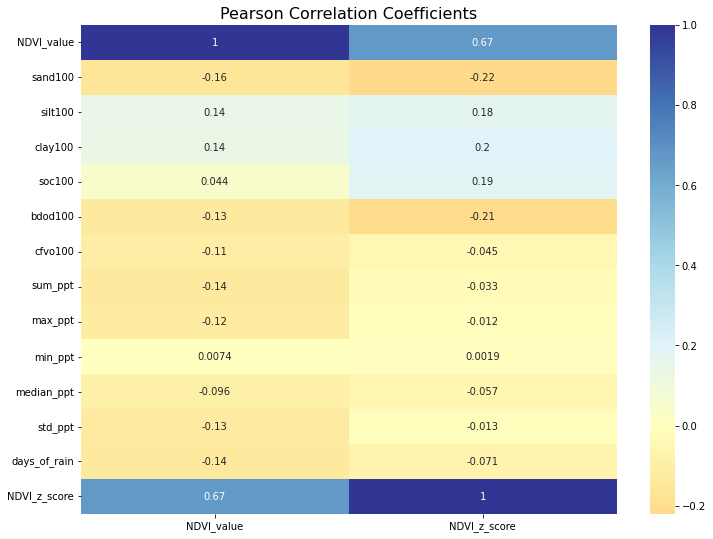

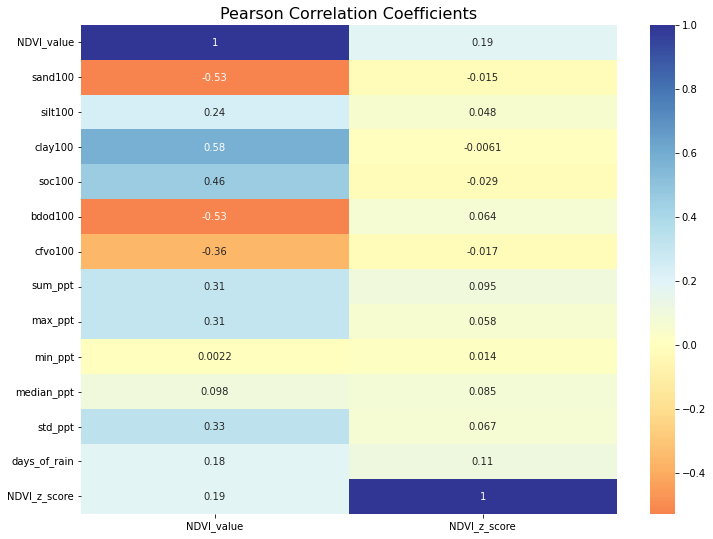

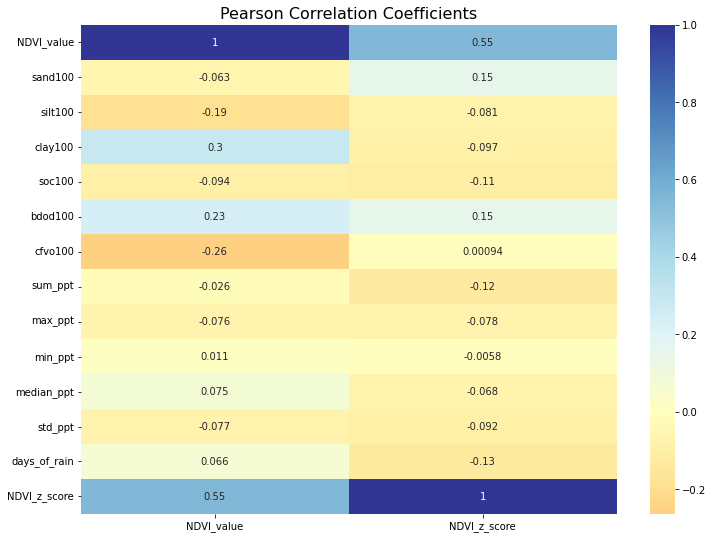

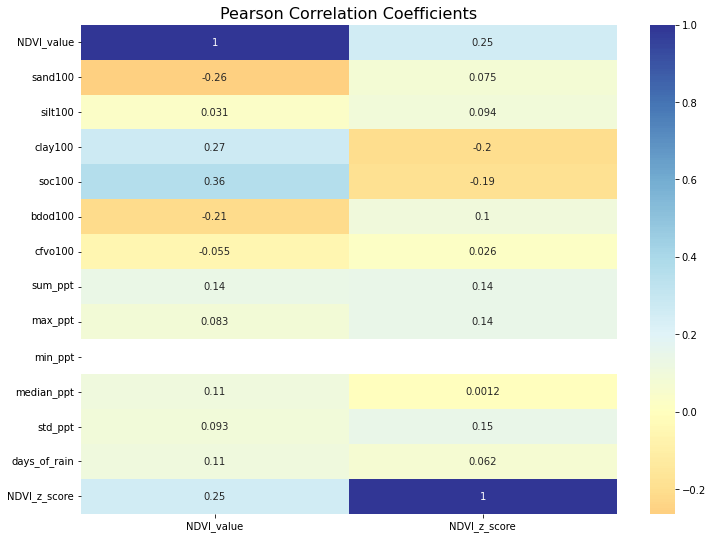

In [275]:
for df in all_df:
    plasma = matplotlib.cm.get_cmap("RdYlBu")
    cols = ['NDVI_value', 
    
       'sand100', 'silt100', 'clay100',
       'soc100', 'bdod100', 'cfvo100', 'sum_ppt', 'max_ppt', 'min_ppt',
       'median_ppt', 'std_ppt', 'days_of_rain', 'NDVI_z_score']
    plotdf = df[cols].sample(n=200000)
    plt.subplots(figsize=(12,9))
    sns.heatmap(plotdf.corr()[['NDVI_value', 'NDVI_z_score']], annot = True, cmap = plasma, center = 0)
    plt.title(("Pearson Correlation Coefficients"), fontsize = 16)
    plt.savefig(("F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Descriptive_stats\\corr_heatmaps\\" + "corr_heatmap_" + df.name + ".jpg"))
    

In [7]:
# create datasets - 48 in total 
#soil variable depths to consider
depths = ["30", '60', '100']
# land use to consider
lulc = ['cropland','grassland', 'shrub', 'trees']

#dictionary of dataframe name and dataframe - FULL DATA
def get_dataframes(base_sets):
    powerset_df = []
    powerset_all_depths = []
    for df in base_sets:
        for l in lulc:
            minus_lulc_cols = [col for col in df.columns if col not in lulc and col not in ['Unnamed: 0', 'Date']]
            lulc_name = (df.name + "_"+ l)
            lulc_df = df[df[l]>0][minus_lulc_cols]
#             lulc_df = df[df[l]==0][minus_lulc_cols]
            lulc_df.name = lulc_name
            powerset_all_depths.append(lulc_df)

            for depth in depths: 
                outdf_name = (df.name +"_"+ depth +"_"+ l)
                #pull appropriate soil columns
                select_cols = [col for col in df.columns if depth in col]
                #add back other columns needed
                select_cols.extend(['sum_ppt', 'max_ppt', 'min_ppt',
                                    'median_ppt', 'std_ppt', 'days_of_rain', "NDVI_dist", 'NDVI_z_score', "mean_NDVI", "NDVI_value", "stdv_NDVI"])
                #subset the original dataframe
                good2go = df[df[l]>0][select_cols]
                good2go.name = outdf_name
                powerset_df.append(good2go)
                
    return (powerset_df, powerset_all_depths)

In [92]:
base_sets = [tur_pos, tur_neg, nar_pos, nar_neg]
# pull train test splits in tuples for each base df
train_test_set = [train_test_split(df, test_size = .2) for df in base_sets]
for i in range(len(base_sets)):
    train_test_set[i][0].name = (base_sets[i].name + "_train")
    train_test_set[i][1].name = (base_sets[i].name + "_test")

In [93]:
# get full datasets
powerset_df, powerset_all_depths = get_dataframes(base_sets)
# get train and test datasets
powerset_df_train, powerset_all_depths_train = get_dataframes([i[0] for i in train_test_set])
powerset_df_test, powerset_all_depths_test = get_dataframes([i[1] for i in train_test_set])

In [94]:
# pull full profile dataframes
df100 = [df for df in powerset_df if "100" in df.name]
df100train = [df for df in powerset_df_train if "100" in df.name]
df100test = [df for df in powerset_df_test if "100" in df.name]

In [364]:
tur.days

Index(['Unnamed: 0', 'Date', 'NDVI_value', 'mean_NDVI', 'stdv_NDVI',
       'cropland', 'trees', 'grassland', 'shrub', 'sand30', 'sand60',
       'sand100', 'silt30', 'silt60', 'silt100', 'clay30', 'clay60', 'clay100',
       'soc30', 'soc60', 'soc100', 'bdod30', 'bdod60', 'bdod100', 'cfvo30',
       'cfvo60', 'cfvo100', 'sum_ppt', 'mean_ppt', 'max_ppt', 'min_ppt',
       'median_ppt', 'std_ppt', 'days_of_rain', 'NDVI_z_score', 'NDVI_dist'],
      dtype='object')

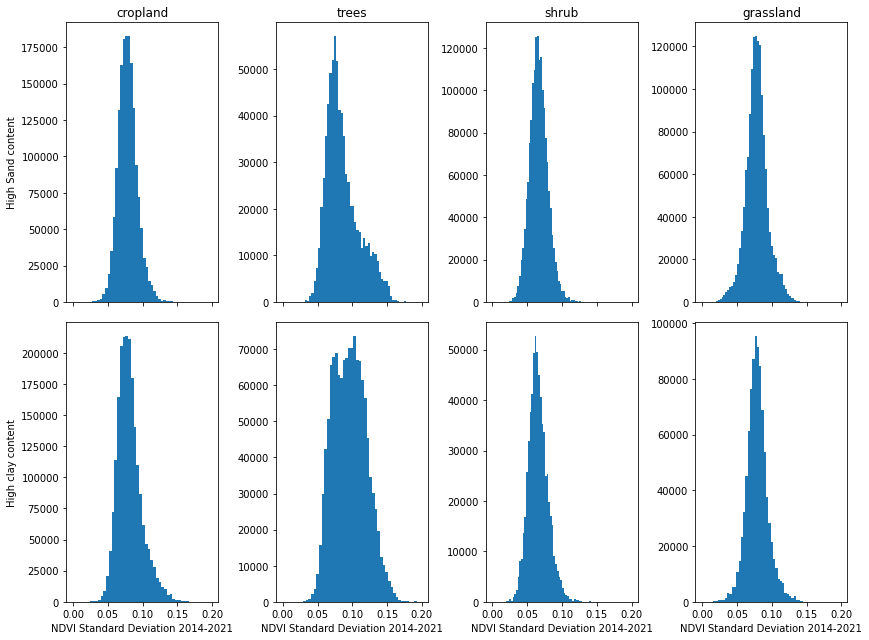

In [382]:
fig, axs = plt.subplots(2, 4, figsize = (12,9), sharex = True)
var = "stdv_NDVI"
xlabel = "NDVI Standard Deviation 2014-2021"
plot_df = nar
axs[0,0].hist(tur[(tur["cropland"]>0)][var], bins = 50)
axs[0,0].set_title("cropland")
axs[0,0].set_ylabel("Turkana")
axs[0,1].hist(tur[(tur["trees"]>0)][var], bins = 50)
axs[0,1].set_title("trees")
axs[0,2].hist(tur[(tur["shrub"]>0)][var], bins = 50)
axs[0,2].set_title("shrub")
axs[0,3].hist(tur[(tur["grassland"]>0)][var], bins = 50)
axs[0,3].set_title("grassland")

axs[1,0].hist(nar[(nar["cropland"]>0)][var], bins = 50)
axs[1,0].set_ylabel("Narok")
axs[1,0].set_xlabel(xlabel)
axs[1,1].hist(nar[(nar["trees"]>0)][var], bins = 50)
axs[1,1].set_xlabel(xlabel)
axs[1,2].hist(nar[(nar["shrub"]>0)][var], bins = 50)
axs[1,2].set_xlabel(xlabel)
axs[1,3].hist(nar[(nar["grassland"]>0)][var], bins = 50)
axs[1,3].set_xlabel(xlabel)


# axs[0,0].hist(plot_df[(plot_df["cropland"]>0) & (plot_df["sand100"] > plot_df["sand100"].mean())][var], bins = 50)
# axs[0,0].set_title("cropland")
# axs[0,0].set_ylabel("High Sand content")
# axs[0,1].hist(plot_df[(plot_df["trees"]>0) & (plot_df["sand100"] > plot_df["sand100"].mean())][var], bins = 50)
# axs[0,1].set_title("trees")
# axs[0,2].hist(plot_df[(plot_df["shrub"]>0) & (plot_df["sand100"] > plot_df["sand100"].mean())][var], bins = 50)
# axs[0,2].set_title("shrub")
# axs[0,3].hist(plot_df[(plot_df["grassland"]>0) & (plot_df["sand100"] > plot_df["sand100"].mean())][var], bins = 50)
# axs[0,3].set_title("grassland")
# axs[1,0].hist(plot_df[(plot_df["cropland"]>0) & (plot_df["clay100"] > plot_df["clay100"].mean())][var], bins = 50)
# axs[1,0].set_ylabel("High clay content")
# axs[1,0].set_xlabel(xlabel)
# axs[1,1].hist(plot_df[(plot_df["trees"]>0) & (plot_df["clay100"] > plot_df["clay100"].mean())][var], bins = 50)
# axs[1,1].set_xlabel(xlabel)
# axs[1,2].hist(plot_df[(plot_df["shrub"]>0) & (plot_df["clay100"] > plot_df["clay100"].mean())][var], bins = 50)
# axs[1,2].set_xlabel(xlabel)
# axs[1,3].hist(plot_df[(plot_df["grassland"]>0) & (plot_df["clay100"] > plot_df["clay100"].mean())][var], bins = 50)
# axs[1,3].set_xlabel(xlabel)
# axs[2,0].hist(plot_df[(plot_df["cropland"]>0) & (plot_df["clay100"] > plot_df["clay100"].mean())][var], bins = 50)
# axs[2,1].hist(plot_df[(plot_df["trees"]>0) & (plot_df["clay100"] > plot_df["clay100"].mean())][var], bins = 50)
# axs[2,2].hist(plot_df[(plot_df["shrub"]>0) & (plot_df["clay100"] > plot_df["clay100"].mean())][var], bins = 50)
# axs[2,3].hist(plot_df[(plot_df["grassland"]>0) & (plot_df["clay100"] > plot_df["clay100"].mean())][var], bins = 50)
plt.tight_layout()
plt.savefig("F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Descriptive_stats\\soil_tex_hist\\nar_sand_v_clay_NDVIstd.jpg")

In [386]:
tur_lulc_counts = []
tur_lulc_counts.append(len(tur[tur.cropland > 0]))
tur_lulc_counts.append(len(tur[tur.grassland > 0]))
tur_lulc_counts.append(len(tur[tur.shrub > 0]))
tur_lulc_counts.append(len(tur[tur.trees > 0]))

nar_lulc_counts = []
nar_lulc_counts.append(len(nar[nar.cropland > 0]))
nar_lulc_counts.append(len(nar[nar.grassland > 0]))
nar_lulc_counts.append(len(nar[nar.shrub > 0]))
nar_lulc_counts.append(len(nar[nar.trees > 0]))

In [390]:
nar_lulc_counts

[4010741, 1988859, 2265414, 1885082]

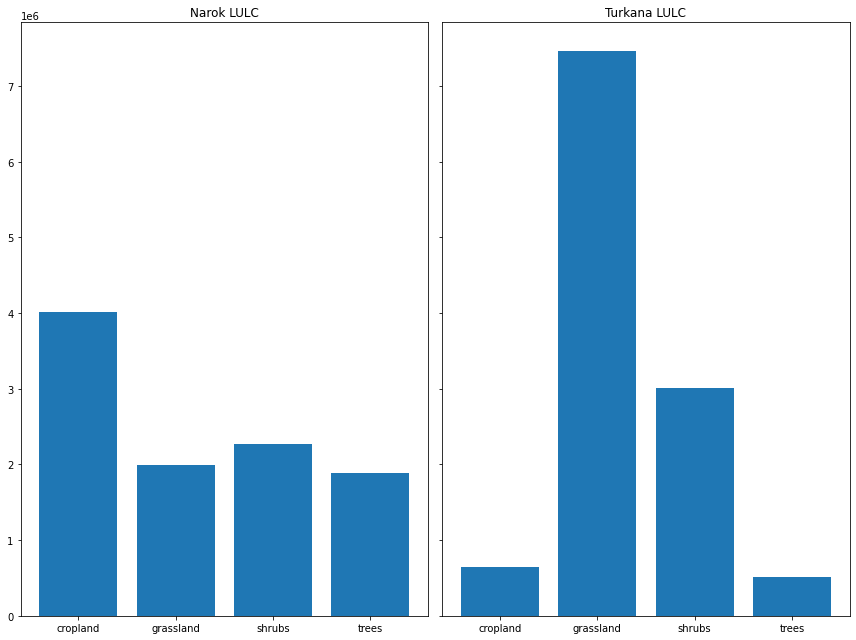

In [394]:
fig, axs = plt.subplots(1,2, figsize = (12,9), sharex = True, sharey = True)
x = ["cropland", "grassland", "shrubs", "trees"]
axs[0].bar(x, nar_lulc_counts)
axs[0].set_title("Narok LULC")
axs[1].bar(x, tur_lulc_counts)
axs[1].set_title("Turkana LULC")
plt.tight_layout()
plt.savefig("F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Descriptive_stats\\\LULC_hist.jpg")

In [409]:
def get_VIF(df):
    # get X variables, remove all NDVI variables
    X_variables = df[[
       'sand100', 'silt100','clay100',
       'soc100','bdod100', 'cfvo100', 'sum_ppt', 'max_ppt',
       'median_ppt', 'std_ppt', 'days_of_rain']].dropna()
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_variables.columns
    vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
    vif_data.name = df.name + "_VIF"
    return (vif_data)

In [410]:
VIF_dfs = []
for df in df100: 
    VIF_dfs.append(get_VIF(df))

In [411]:
for df in VIF_dfs: 
    VIF_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\Descriptive_stats\\" + df.name + ".png"
    dfi.export(df,VIF_path)

In [400]:
## PCA
# run regression on all datasets
df_explained_var_ratio = {}
df_components = {}
for df in df100:
    plot_title = (df.name).replace("_", " ") + " PCA"
    path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\PCA\\" + df.name + "_PCA.jpg"

    #drop na values - where dates are in the first 16 days of january 2014
    df_clean = df.dropna(axis = 0, how = "any")
    
    #run a PCA
    pca = decomposition.PCA(.95)
    pca.fit(df_clean)
    projected = pca.fit_transform(df_clean)
    
# #     plot data
#     plt.scatter(projected[:, 0], projected[:, 1],
#             c=((df_clean.sand100)/10), edgecolor='none', alpha=0.5,
#             cmap=plt.cm.get_cmap('hot_r'))
#     plt.xlabel('component 1')
#     plt.ylabel('component 2')
#     plt.title(plot_title)
#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel('percent sand content', rotation=270)
#     cbar.ax.yaxis.labelpad = 10
#     plt.savefig(path)
#     plt.close()

    # save output
    df_explained_var_ratio[df.name] = pca.explained_variance_ratio_
    df_components[df.name] = pca.components_

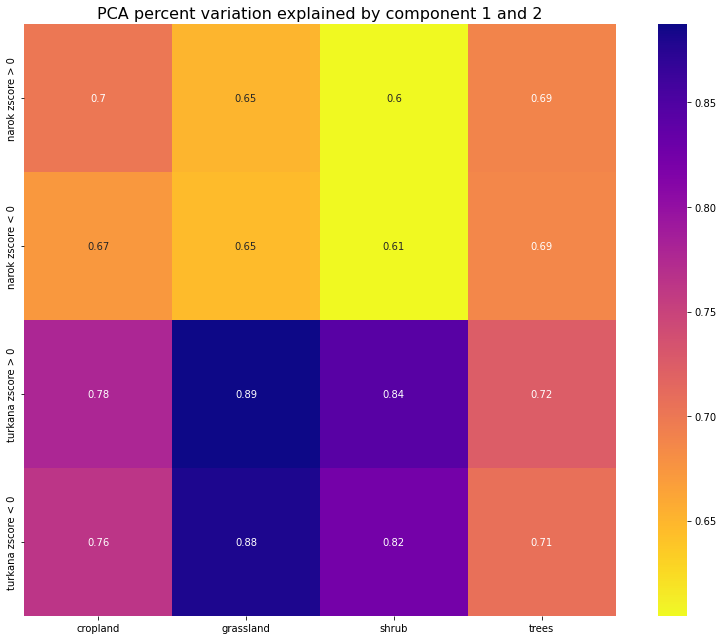

In [403]:
scores = []
all_keys = list(df_explained_var_ratio.keys())
subsets = ['nar_pos', 'nar_neg', 'tur_pos', 'tur_neg']
for s in subsets:
    subset_scores = []
    keys = [key for key in all_keys if s in key]
    for key in keys: 
        var_1_and_2 = df_explained_var_ratio[key][0] +  df_explained_var_ratio[key][1]
        subset_scores.append(var_1_and_2)
    scores.append(subset_scores)
    
# create regression score heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
plasma = matplotlib.cm.get_cmap("plasma_r")
Yaxes = ['narok zscore > 0', 'narok zscore < 0', 'turkana zscore > 0', 'turkana zscore < 0']
Xaxes = ["cropland", "grassland", "shrub", "trees"]

plt.subplots(figsize=(12,9))
sns.heatmap(scores, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = plasma)
plt.title("PCA percent variation explained by component 1 and 2", fontsize = 16);
file_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\PCA_var_explained_by_1_2.jpg"
plt.tight_layout()
plt.savefig(file_path)

In [160]:
# test all combinations of variables and see what produces best linear regression
ppt_vars = ['sum_ppt', 'max_ppt', 'min_ppt', 'median_ppt',
       'std_ppt', 'days_of_rain']
soil_vars = ['sand100',
       'silt100','clay100', 'soc100', 'bdod100',
       'cfvo100']
ndvi_vars = ['NDVI_value']

In [161]:
pick_vars = []
for p in ppt_vars: 
    for s in soil_vars:
        pick_vars.append([p,s])

In [228]:
def regression_fxn(x):
    # run regression on all datasets
    df_scores = {}
    df_coeff = {}
    for i in range(len(df100train)):
    # for df in powerset_all_depths_train: 
        df_train = df100train[i]
        df_test = df100train[i]

        #drop na values - where dates are in the first 16 days of january 2014
        df_clean_train = df_train.dropna(axis = 0, how = "any")
        #pull out x and y columns 
        data_x_train = df_clean_train[x]
        data_y_train = df_clean_train['NDVI_z_score']

        #scale to train data 
        scale = MinMaxScaler().fit(data_x_train)
        scaled_x_train = scale.transform(data_x_train)
        scaled_y_train = data_y_train.array.reshape(-1,1)

        #do the same for the test data
        #drop na values - where dates are in the first 16 days of january 2014
        df_clean_test = df_test.dropna(axis = 0, how = "any")
        #pull out x and y columns 
        data_x_test = df_clean_test[x]
        data_y_test = df_clean_test['NDVI_z_score']
        #scale x and y values 
        scaled_x_test = scale.transform(data_x_test)
        scaled_y_test = data_y_test.array.reshape(-1,1)

        #run a linear regression on training data
        # bagged estimator
        reg = LinearRegression().fit(scaled_x_train, scaled_y_train)

        #save score and coefficients in a dictionary 
        #calculate score based on test data 
        df_scores[df_test.name] = reg.score(scaled_x_test, scaled_y_test)
        df_coeff[df_train.name] = reg.coef_
        
    return(df_scores, df_coeff)

In [240]:
len(pick_vars)

36

In [229]:
all_scores = []
all_coeffs = []
for v in pick_vars: 
    s, c = regression_fxn(v)
    all_scores.append(s)
    all_coeffs.append(c)

In [230]:
scores_matrix = []
for d in range(len(all_scores)): 
    scores_matrix.append([all_scores[d][k] for k in all_scores[d].keys()])

In [231]:
scores_matrix = np.array(scores_matrix)

In [232]:
max_indexes = np.argmax(scores_matrix, axis = 0)

In [233]:
best_vars = {}
for k in range(len(list(all_scores[0].keys()))): 
    best_vars[list(all_scores[0].keys())[k]] = pick_vars[max_indexes[k]]

In [234]:
best_r2 = {}
for k in range(len(list(all_scores[0].keys()))): 
    best_r2[list(all_scores[0].keys())[k]] = scores_matrix[max_indexes[k]][k]

In [235]:
sum_r2 = scores_matrix.sum(axis = 1)
biggest_sum_r2 = np.argmax(sum_r2)
biggest_sum_r2_vars = pick_vars[biggest_sum_r2]
print ([biggest_sum_r2_vars])

mean_r2 = scores_matrix.mean(axis = 1)
biggest_mean_r2 = np.argmax(mean_r2)
biggest_mean_r2_vars = pick_vars[biggest_mean_r2]
print ([biggest_mean_r2_vars])

['sum_ppt', 'sand100']
['sum_ppt', 'sand100']


In [238]:
best_r2

{'tur_pos_train_100_cropland': 0.03866244902708782,
 'tur_pos_train_100_grassland': 0.04421932690614172,
 'tur_pos_train_100_shrub': 0.048270603767851195,
 'tur_pos_train_100_trees': 0.05794869490054899,
 'tur_neg_train_100_cropland': 0.06038929618490729,
 'tur_neg_train_100_grassland': 0.09155946678210414,
 'tur_neg_train_100_shrub': 0.08472169930505147,
 'tur_neg_train_100_trees': 0.06621978566617504,
 'nar_pos_train_100_cropland': 0.011601894612166985,
 'nar_pos_train_100_grassland': 0.009667131049948652,
 'nar_pos_train_100_shrub': 0.008616763146802264,
 'nar_pos_train_100_trees': 0.031171424342317677,
 'nar_neg_train_100_cropland': 0.05459815070241192,
 'nar_neg_train_100_grassland': 0.08440461656569598,
 'nar_neg_train_100_shrub': 0.10782355660956511,
 'nar_neg_train_100_trees': 0.05528725458530037}

In [418]:
# run regression on all datasets
df_scores = {}
df_coeff = {}
for i in range(len(df100train)):
# for df in powerset_all_depths_train: 
    df_train = df100train[i]
    df_test = df100train[i]
    #columns to remove from x
    rm_meX = ["NDVI_z_score", "NDVI_value", "mean_NDVI", "stdv_NDVI", "NDVI_dist", "mean_ppt", "bdod100", "silt100"]
    
    #drop na values - where dates are in the first 16 days of january 2014
    df_clean_train = df_train.dropna(axis = 0, how = "any")
    #pull out x and y columns 
    data_x_train = df_clean_train[[col for col in df_train.columns if col not in rm_meX]]
#     data_x_train = df_clean_train[["sum_ppt", "sand100"]]
    data_y_train = df_clean_train['NDVI_value']
    
    #scale to train data 
    scale = MinMaxScaler().fit(data_x_train)
    scaled_x_train = scale.transform(data_x_train)
    scaled_y_train = data_y_train.array.reshape(-1,1)
    
    #do the same for the test data
    #drop na values - where dates are in the first 16 days of january 2014
    df_clean_test = df_test.dropna(axis = 0, how = "any")
    #pull out x and y columns 
    data_x_test = df_clean_test[[col for col in df_test.columns if col not in rm_meX]]
#     data_x_test = df_clean_test[["sum_ppt", "sand100"]]
    data_y_test = df_clean_test['NDVI_value']
    #scale x and y values 
    scaled_x_test = scale.transform(data_x_test)
    scaled_y_test = data_y_test.array.reshape(-1,1)
    
    #run a linear regression on training data
    # bagged estimator
#     reg = BaggingRegressor(base_estimator=LinearRegression(), n_estimators=10, max_samples =.7, bootstrap_features = True, random_state=0).fit(scaled_x_train, scaled_y_train)
    reg = LinearRegression().fit(scaled_x_train, scaled_y_train)
#     reg = LinearRegression().fit(data_x_train, data_y_train)

    #save score and coefficients in a dictionary 
    #calculate score based on test data 
    df_scores[df_test.name] = reg.score(scaled_x_test, scaled_y_test)
#     df_scores[df_test.name] = reg.score(data_x_test, data_y_test)
    df_coeff[df_train.name] = reg.coef_

In [419]:
# pull the scores and sort them to put into a heatmap
scores = []
leftaxis = [df.name for df in base_sets]

for a in leftaxis: 
    a_list = []
    keys = [key for key in list(df_scores.keys()) if a in key]
    for k in keys: 
        a_list.append(df_scores[k])
    scores.append(a_list)

In [420]:
scores

[[0.042315286120719775,
  0.1467385139799866,
  0.12611553779185447,
  0.09224729300233137],
 [0.07655303380389811,
  0.346496454325654,
  0.3500498432688527,
  0.12612519345811457],
 [0.1567232547823949,
  0.11339266073051069,
  0.07904573533885428,
  0.07526805313777829],
 [0.2115115311519139,
  0.23060485629505256,
  0.1455193636867843,
  0.24990901956510325]]

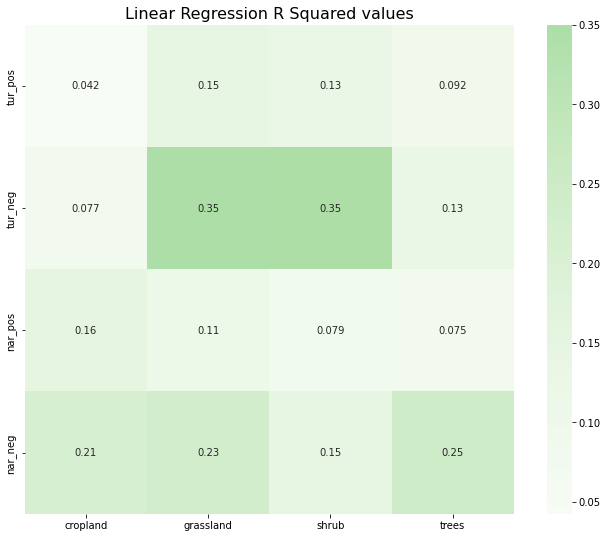

In [422]:
# create regression score heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
greens = matplotlib.cm.get_cmap("Greens")

Yaxes = [df.name for df in base_sets]
Xaxes = ["cropland", "grassland", "shrub", "trees"]

plt.subplots(figsize=(12,9))
sns.heatmap(scores, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = greens, center = .5)
plt.title(("Linear Regression R Squared values"), fontsize = 16);
file_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\LR_output_full_profile\\rsq_pred_NDVI_value_subset_by_zscore_minus_bdod_sand.jpg"
plt.savefig(file_path)

In [423]:
# pull the coefficients and sort them to put into a heatmap
coefficients = []
leftaxis = list(df_coeff.keys())
for a in leftaxis: 
    coefficients.append(list(df_coeff[a].flatten()))

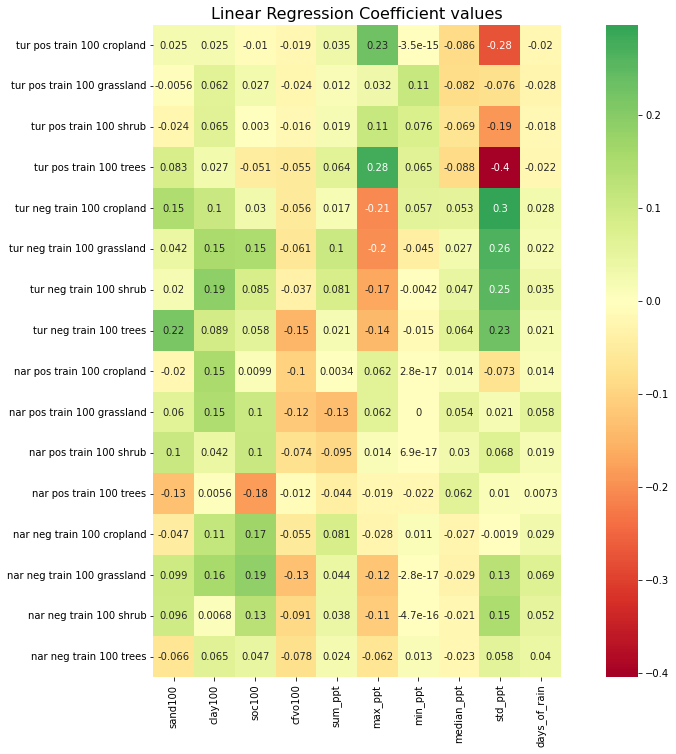

In [425]:
# create regression coefficient heatmap
RdYlGn = matplotlib.cm.get_cmap("RdYlGn")
rm_meX = ["NDVI_z_score", "NDVI_value", "mean_NDVI", "stdv_NDVI", "NDVI_dist", "mean_ppt", "bdod100","silt100"]
Yaxes = [col.replace("_", " ") for col in leftaxis]
Xaxes = [col for col in df100train[0].columns if col not in rm_meX]
# Xaxes = ["sum_ppt", "sand100"]

plt.subplots(figsize=(16,12))
sns.heatmap(coefficients, annot = True, xticklabels = Xaxes, yticklabels = Yaxes, square=True, cmap = RdYlGn, center = 0)
plt.title("Linear Regression Coefficient values", fontsize = 16);
file_path = "F:\\Tara_Fall_2019\\Kenya_Drought\\FIGURES\\coeff_pred_NDVI_value_subset_by_zscore_minus_bdod_sand.jpg"
plt.savefig(file_path)